In [29]:
suppressPackageStartupMessages({
    library(SingleCellExperiment) 
    library(scran)
    library(dplyr)
    library(ggplot2)
    library(scater)
    library(gridExtra)
    library(ggthemes)
    library(ggsankey)
    library(APL)
    library(plotly)    
    library(CAbiNet) 
    })

## Load the pre-processed data

In [30]:
## If you haven't run through preprocessing steps, please first load the preprocessed dataset 'PBMC_10X_filtered.rds' from the online repository https://zenodo.org/deposit/7433294 to folder Preprocessing//ExperimentalData/preprocessed/ 
## or load it from anywhere you have it in your local directory and load it as sce

In [31]:
sce = readRDS('../Data/real_data/preprocessed/PBMC_10X_filtered.rds')

sce

class: SingleCellExperiment 
dim: 11881 3176 
metadata(2): study scDblFinder.stats
assays(2): counts logcounts
rownames(11881): ENSG00000000003 ENSG00000000419 ... ENSG00000283013
  ENSG00000283103
rowData names(2): SYMBOL scDblFinder.selected
colnames(3176): pbmc2_10X_V2_AAACCTGAGATGGGTC
  pbmc2_10X_V2_AAACCTGAGCGTAATA ... pbmc2_10X_V2_TTTGTCATCAGTACGT
  pbmc2_10X_V2_TTTGTCATCGGCCGAT
colData names(26): NAME nGene ... scDblFinder.mostLikelyOrigin
  scDblFinder.originAmbiguous
reducedDimNames(2): PCA UMAP
mainExpName: NULL
altExpNames(0):

In [32]:

algorithm = 'leiden'
prune = 1/15
resol = 1
usegap = NULL
SNN_mode = 'all'
ntop = 2000
truth = 'truth'
dims = 80
NNs = c(20, 20, 10, 50)
graph_select <- FALSE
gcKNN <- TRUE

nclust = NULL

data = sce

  if (!is.na(ntop)){

        genevars <- modelGeneVar(data, assay.type = "logcounts")

#         if (isTRUE(graph_select)){

#             chosen <- getTopHVGs(genevars, prop = 0.8, var.threshold = NULL)

#         } else {

            chosen <- getTopHVGs(genevars, n = ntop, var.threshold = NULL)

        # }

        data_old <- data
        data <- data[chosen,]
    }
    
    # rename rows of data as gene AYMBOL
    rowData(data)$ENSMBL = rownames(data)
    rowData(data)$GeneName = rowData(data)$SYMBOL
    idx = which(is.na(rowData(data)$GeneName ))
    rowData(data)$GeneName[idx] = rownames(rowData(data))[idx]
    idx = duplicated(rowData(data)$GeneName)
    rowData(data)$GeneName[idx] = paste0(rowData(data)$GeneName[idx], '_', rowData(data)$ENSMBL[idx])
    rownames(data) = rowData(data)$GeneName

    
    cnts <- as.matrix(logcounts(data))


    trueclusters = colData(data)[,colnames(colData(data)) == truth]



In [33]:
dim(data)
dim(cnts)

[1] 2000 3176

[1] 2000 3176

## Correspondence Analysis

In [34]:
# Correspondence Analysis
## use logcounts as input of cacomp

caobj = cacomp(cnts,
               dims = dims,
               ntop = nrow(cnts),
               python = TRUE, 
              clip = TRUE)

prinInertia <- caobj@D^2
    percentInertia <- prinInertia / sum(prinInertia) * 100

    # Saving the results
    ca <- caobj@std_coords_cols
    attr(ca, "prin_coords_rows") <- caobj@prin_coords_rows
    attr(ca, "singval") <- caobj@D
    attr(ca, "percInertia") <- percentInertia
    attr(ca, "params") <- caobj@params
    
    SingleCellExperiment::reducedDim(data, "CA") <- ca

Warning message in run_cacomp(obj = obj, coords = coords, princ_coords = princ_coords, :
“
Parameter top is >nrow(obj) and therefore ignored.”


## Run the CAbiNet biclustering algorithm with function 'caclust'

In [35]:
### Tips: upgrage the reticulate package to > 1.26

In [36]:
# cabimem <- profvis::profvis({

set.seed(66)
data <- caclust(obj = data,
              k = NNs,
              loops = FALSE,
              SNN_prune = prune,
              mode = SNN_mode,
              resolution = resol,
              select_genes = graph_select,
              prune_overlap = FALSE,
              calc_gene_cell_kNN = gcKNN,
              algorithm = 'leiden',
              leiden_pack = 'leiden',
              rand_seed = 66)
# })

In [37]:
ARI = mclust::adjustedRandIndex(data$caclust, data$truth)


In [38]:
ARI

[1] 0.7882308

## CA biplot 

Warning message in ggplot2::geom_point(data = rows, ggplot2::aes_(x = as.name(rnmx), :
“Ignoring unknown aesthetics: text”
Warning message in ggplot2::geom_point(data = cols, ggplot2::aes_(x = as.name(cnmx), :
“Ignoring unknown aesthetics: text”


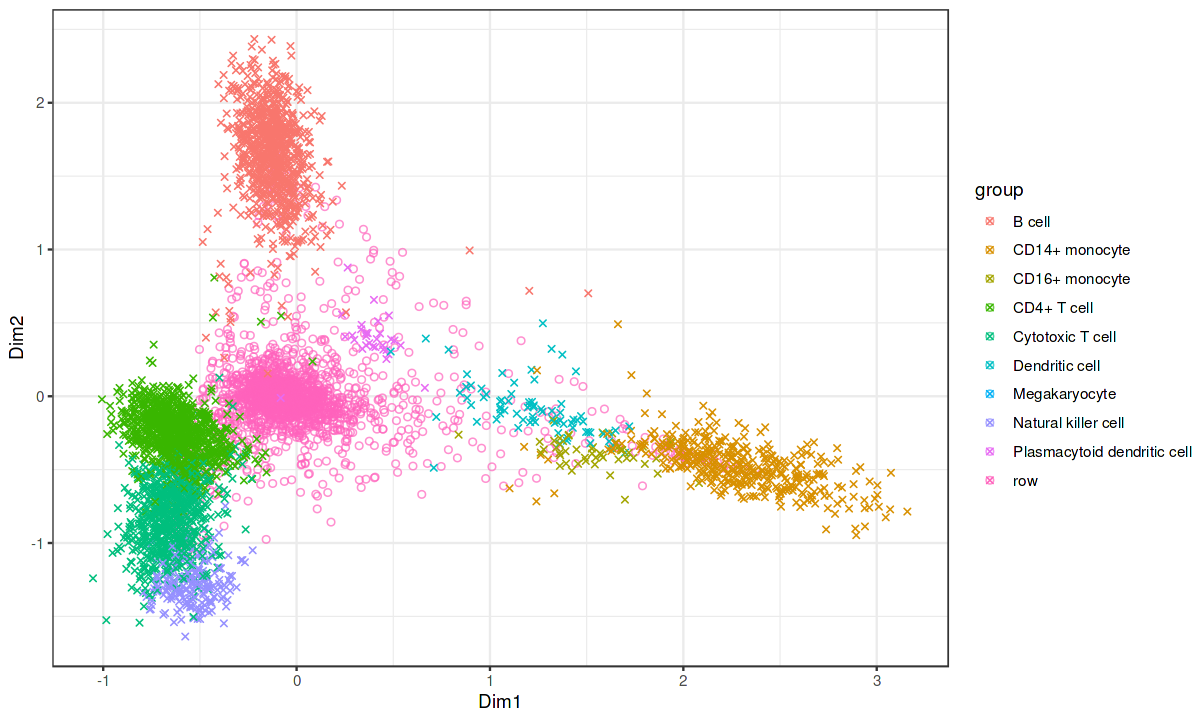

In [39]:
options(repr.plot.width=10, repr.plot.height=6)

clist = data$truth
names(clist) = colnames(data)

ca_biplot(caobj, col_metadata = clist)

In [40]:
## Number of cells in each expert annotated cell types
summary(as.factor(data$truth)) %>% as.data.frame()

.  
B cell                      819
CD14+ monocyte              388
CD16+ monocyte               50
CD4+ T cell                 928
Cytotoxic T cell            675
Dendritic cell               76
Megakaryocyte                 1
Natural killer cell         209
Plasmacytoid dendritic cell  30

## biclustering results from CAbiNet

In [41]:
metadata(data)$caclust

caclust object with 3176 cells and 2000 genes.
22 clusters found.
Clustering results:

 cluster ncells ngenes
 1       870    104   
 2         0    876   
 3       664     32   
 4        68    548   
 5       488    101   
 6       372    124   
 7       312     23   
 8       227     58   
 9        54     54   
 10       90     13   
 11       31     55   
 12        0      2   
 13        0      1   
 14        0      1   
 15        0      1   
 16        0      1   
 17        0      1   
 18        0      1   
 19        0      1   
 20        0      1   
 21        0      1   
 22        0      1   

### Remove clusters which has too few genes or cells

In [42]:
source('helpers.R')

subdata = rm_raremonoclusters_sce(data)
metadata(subdata)$caclust

Loading required package: viridisLite


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


The following object is masked from ‘package:S4Vectors’:

    expand


circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))


Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:plotly’:

    select


The following object is masked from ‘package:genefilter’:

    area


The following object is masked from ‘package:dplyr’:

    select


Loading required package: colorspace

Loading required package: lattice


Attaching pa

caclust object with 3176 cells and 2000 genes.
11 clusters found.
Clustering results:

 cluster ncells ngenes
 1       870    104   
 2       664     32   
 3       488    101   
 4       372    124   
 5       312     23   
 6       227     58   
 7        90     13   
 8        68    548   
 9        54     54   
 10       31     55   
 11        0    876   

## Figure 2b: the Sankey Plot shows the consistendency between expert annotated cell types and CAbiNet biclustering results

Warning message:
“attributes are not identical across measure variables;
they will be dropped”
`summarise()` has grouped output by 'Biclusters'. You can override using the
`.groups` argument.


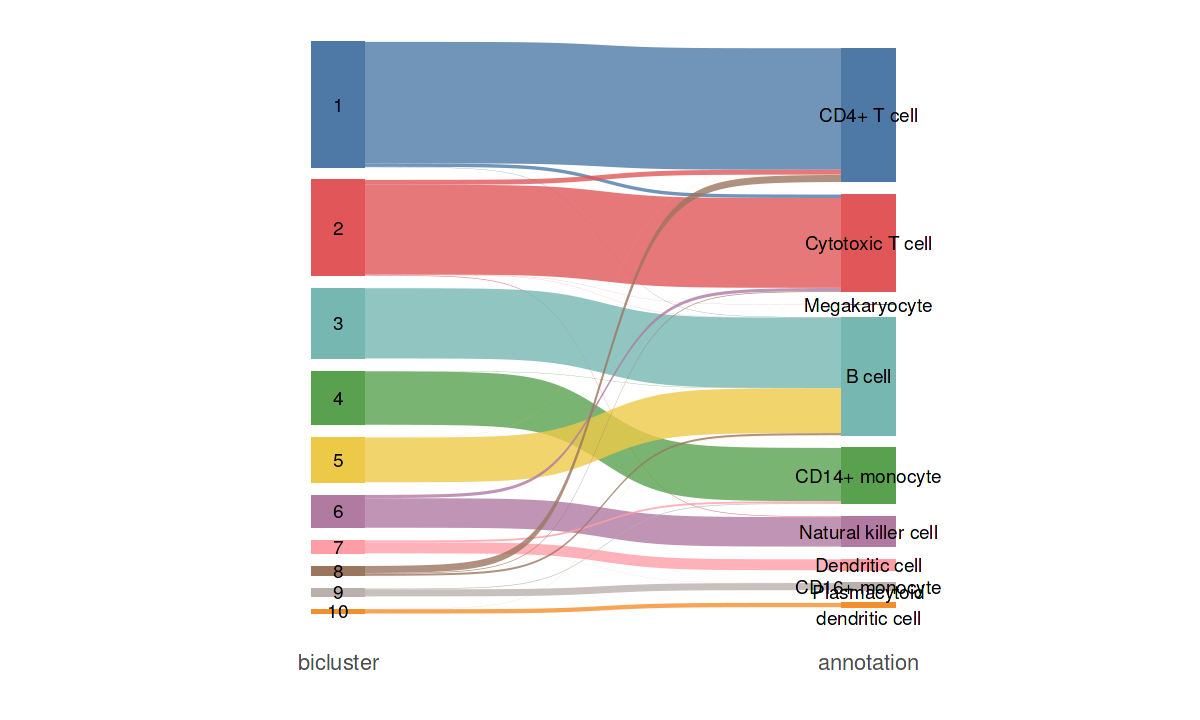

In [43]:
library(ggsankey)
sce_sub = subdata

coldf = colData(subdata)
coldf$annotation = coldf$truth
coldf$bicluster = coldf$caclust

truth_label = 'bicluster'
caclust_label = 'annotation'

df <- coldf %>% as_tibble() %>% dplyr::select(annotation, bicluster) %>%
    make_long(bicluster, annotation)
    # make_long(annotation, bicluster)


info  <-  data.frame(Biclusters = as.factor(coldf$bicluster),
                  Truth = as.character(coldf$annotation)) %>%  
                as_tibble() %>%
                group_by(Biclusters, Truth) %>% 
                summarise(n = n()) %>%
                mutate(Partition = n/sum(n)) %>%
                dplyr::select(-c(n)) %>%
                ungroup() %>% 
                as.data.frame() %>% 
                group_by(Biclusters) %>%
                filter(Partition == max(Partition) ) %>%
                dplyr::select(Biclusters, Truth) %>%
                distinct(Biclusters, .keep_all = TRUE)

    # cts <- unique(coldf$annotation)
    cts <- sort(unique(as.character(coldf$bicluster)))


    if (length(cts) > 10){
        tbl_col <- "Tableau 20"
    } else {
        tbl_col <- "Tableau 10"
    }
    
    pal <- tableau_color_pal(tbl_col)

    cols <- pal(length(cts))
                
    # info <- left_join(data.frame("Truth" = cts, "col" = cols), info, by = "Truth")
    info <- left_join(data.frame("Biclusters" = cts, "col" = cols), info, by = "Biclusters")
    
    cols <- c(cols, info$col)
    
    # names(cols) <- c(as.character(cts), as.character(info$Biclusters))
    names(cols) <- c(as.character(info$Biclusters), as.character(info$Truth))

order <- c("1",
           "2",
           "3",
           "4",
           "5",
           "6",
           "7",
           "8",
           "9",
           "10",
            "CD4+ T cell",
            "Cytotoxic T cell",
           "Megakaryocyte",
            "B cell", 
          "CD14+ monocyte",
          "Natural killer cell",
           "Dendritic cell",
           "CD16+ monocyte",
           "Plasmacytoid dendritic cell")

order = order[seq(to = 1, by = -1, length.out = length(order))]

wrap <- length(order)
df$node <- factor(stringr::str_wrap(df$node, wrap), levels = stringr::str_wrap(order, wrap))
df$next_node <- factor(stringr::str_wrap(df$next_node, wrap), levels = stringr::str_wrap(order, wrap))

names(cols) <- stringr::str_wrap(names(cols), wrap)

sank <- ggplot(df, aes(x = x, 
               next_x = next_x, 
               node = node, 
               next_node = next_node,
               fill = node,
               label = as.character(node))) +
  geom_sankey(flow.alpha = 0.8) +
  # geom_sankey_label(size = 2, color = "black",  hjust = -1)+ #fill= "white",
  geom_sankey_text() +
# geom_sankey_text(size = 3, color = "black", fill = NA, hjust = 0, position = position_nudge(x = 0.1))+
  labs(x = "") +
  scale_fill_manual(values = cols) +
  theme_sankey(base_size = 16) +
  theme(legend.position = "none") 


options(repr.plot.width=10, repr.plot.height=6)

sank


In [44]:
ggsave('imgs/Fig2b_sankeyPlot_pbmc10x_annotation_biclusters.png', sank, width = 6, height = 4)
ggsave('imgs/Fig2b_sankeyPlot_pbmc10x_annotation_biclusters.pdf', sank, width = 6, height = 4)


In [45]:
truth_cols = cols[names(cols) %in% unique(subdata$truth)]
ca_cols = cols[names(cols) %in% unique(coldf$bicluster)]

## The UMAP embedding with cells colored by expert annotated cell types (left) and CAbiNet biclustering results (right)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


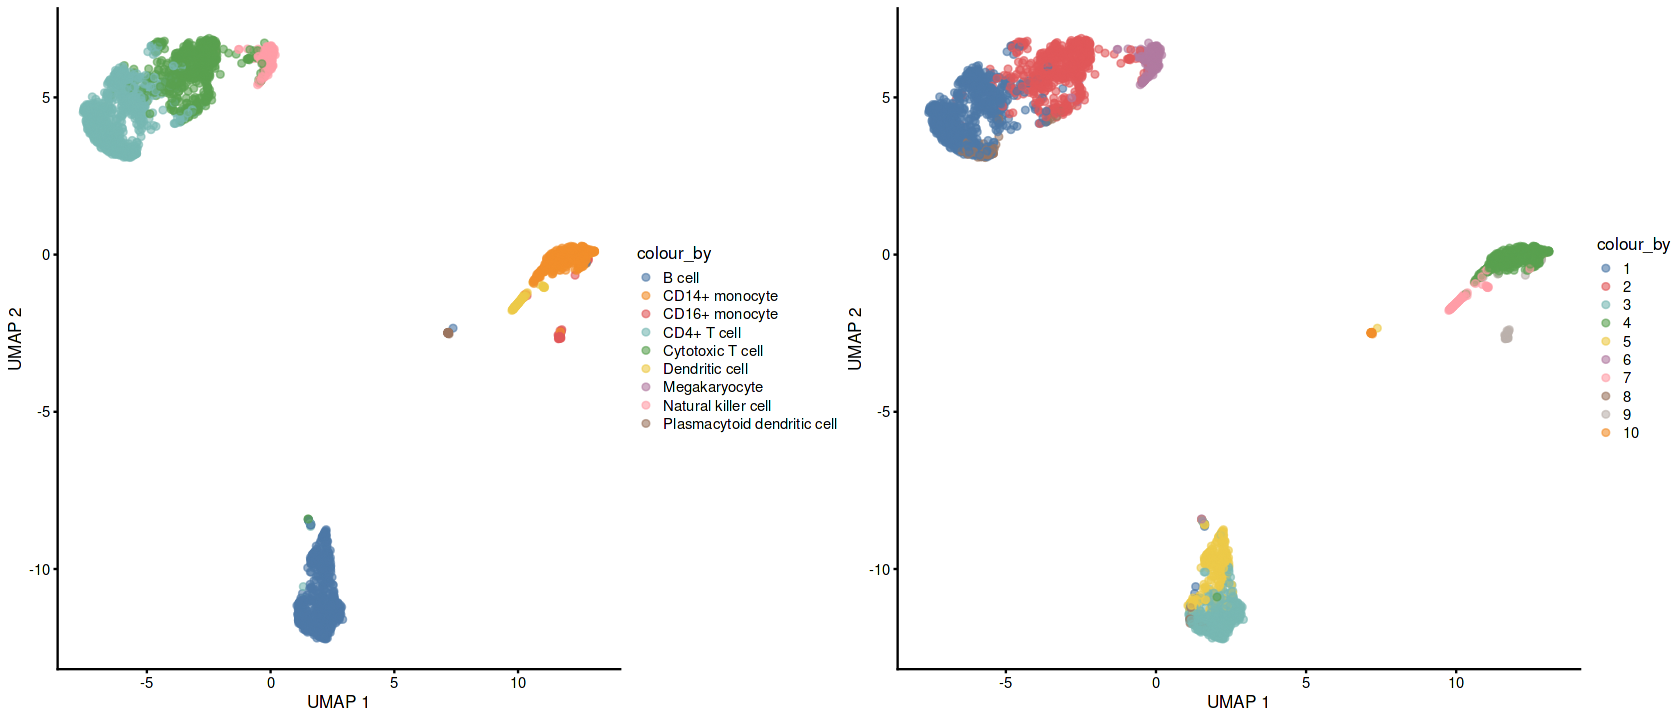

In [46]:
options(repr.plot.width=14, repr.plot.height=6)

p1 = plotUMAP(subdata, colour_by = 'truth') + scale_color_tableau(
  palette = "Tableau 10",
  type = "regular",
  direction = 1
)

p2 = plotUMAP(subdata, colour_by = 'caclust')  +   scale_color_manual(values = ca_cols) + 
        scale_fill_manual(values = ca_cols)
p = grid.arrange(p1, p2, nrow = 1)


## Figure 2a: biMAP - a joint visualization of cells and corresponding 'marker' genes
### The biMAPs with expert annotated cell types (on the left) and the biclustering results (on the right)

Module(umap)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


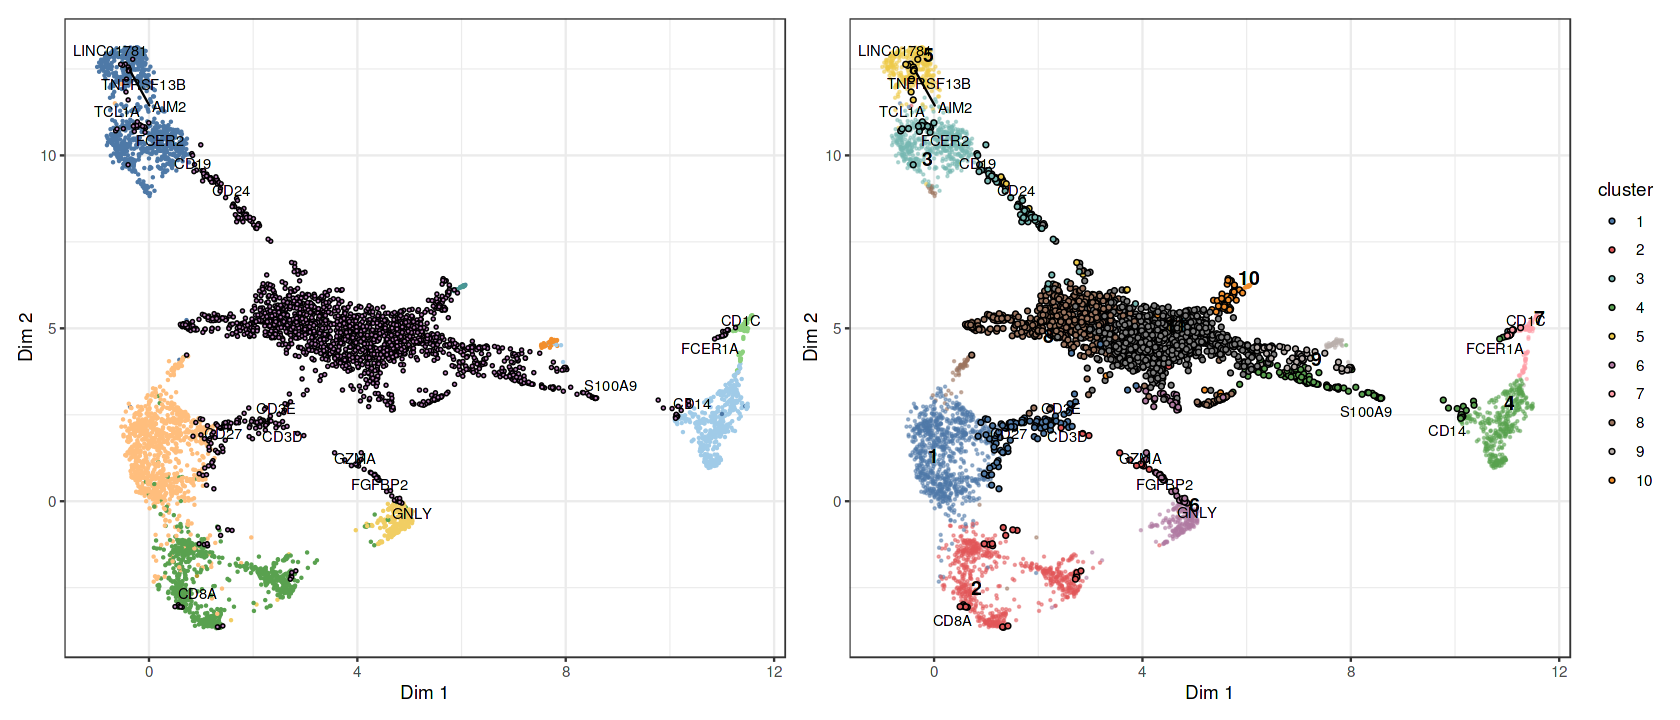

In [51]:
## Run biMAP function to get the coordinates of genes and cells in a biMAP
## Then the biMAP is visualized by function plot_biMAP
reticulate::import("umap")

subdata = CAbiNet::biMAP(subdata, k = 10, method = 'SNNdist', rand_seed = 66)

viplist = c('CD3D', 'CD3E','CD4', 'CD8A', 'CD14', 'KLRCF', 'MS4A', 'CD38', 'FGFBP2', 'SLAMF7', 'CD27', 'CD19', 'FCER1A', 'TCL1A', 'CD1C')
viplist = c(viplist, 'FCER2', 'GNLY', 'S100A9', 'GZMA', 'AIM2', 'CD24', 'LINC01781', 'TNFRSF13B')

p1 = plot_biMAP(subdata,  color_by = 'truth', color_genes = TRUE, label_groups = FALSE,
                 label_marker_genes = viplist,
                cell_size = 0.2, gene_size = 0.5, cell_alpha = 1, gene_alpha = 1 ) + 
        theme(legend.position = 'none') + 
        scale_color_tableau(
                                      palette = "Tableau 20",
                                      type = "regular",
                                      direction = 1)
p2 = plot_biMAP(subdata,  color_by = 'cluster', color_genes = TRUE,
                 label_marker_genes = viplist,
               cell_size = 0.2, gene_size = 1, cell_alpha = 0.5, gene_alpha = 1 ) +
    # theme(legend.position = 'none')+ 
        geom_text_repel(max.overlaps = Inf) +
          scale_color_manual(values = ca_cols) + 
        scale_fill_manual(values = ca_cols)

options(repr.plot.width=14, repr.plot.height=6)

p1 + p2

In [52]:
ggsave("imgs/Fig2a_pbmc10x_bimap_bicluster.png", p2, width = 4, height = 3)
ggsave("imgs/Fig2a_pbmc10x_bimap_bicluster.pdf", p2, width = 4, height = 3)

In [22]:
# py_install('umap-learn')
# py_config()
# globalenv()

In [23]:
# use_python("/home/zhao/mambaforge/bin/python")
# import('umap')

## The interactive version of Figure 2a

In [24]:
fig = plotly::ggplotly(p2)
fig

Warning message in geom2trace.default(dots[[1L]][[1L]], dots[[2L]][[1L]], dots[[3L]][[1L]]):
“geom_GeomTextRepel() has yet to be implemented in plotly.
  If you'd like to see this geom implemented,
  Please open an issue with your example code at
  https://github.com/ropensci/plotly/issues”
Warning message in geom2trace.default(dots[[1L]][[1L]], dots[[2L]][[1L]], dots[[3L]][[1L]]):
“geom_GeomTextRepel() has yet to be implemented in plotly.
  If you'd like to see this geom implemented,
  Please open an issue with your example code at
  https://github.com/ropensci/plotly/issues”


HTML widgets cannot be represented in plain text (need html)

In [25]:
htmlwidgets::saveWidget(as_widget(fig), "SupplM1_Fig2a_pbmc10x_biclusters_plotly.html")


## Figure 2c: the feature biMAPs with cells colored by the expression level of marker genes

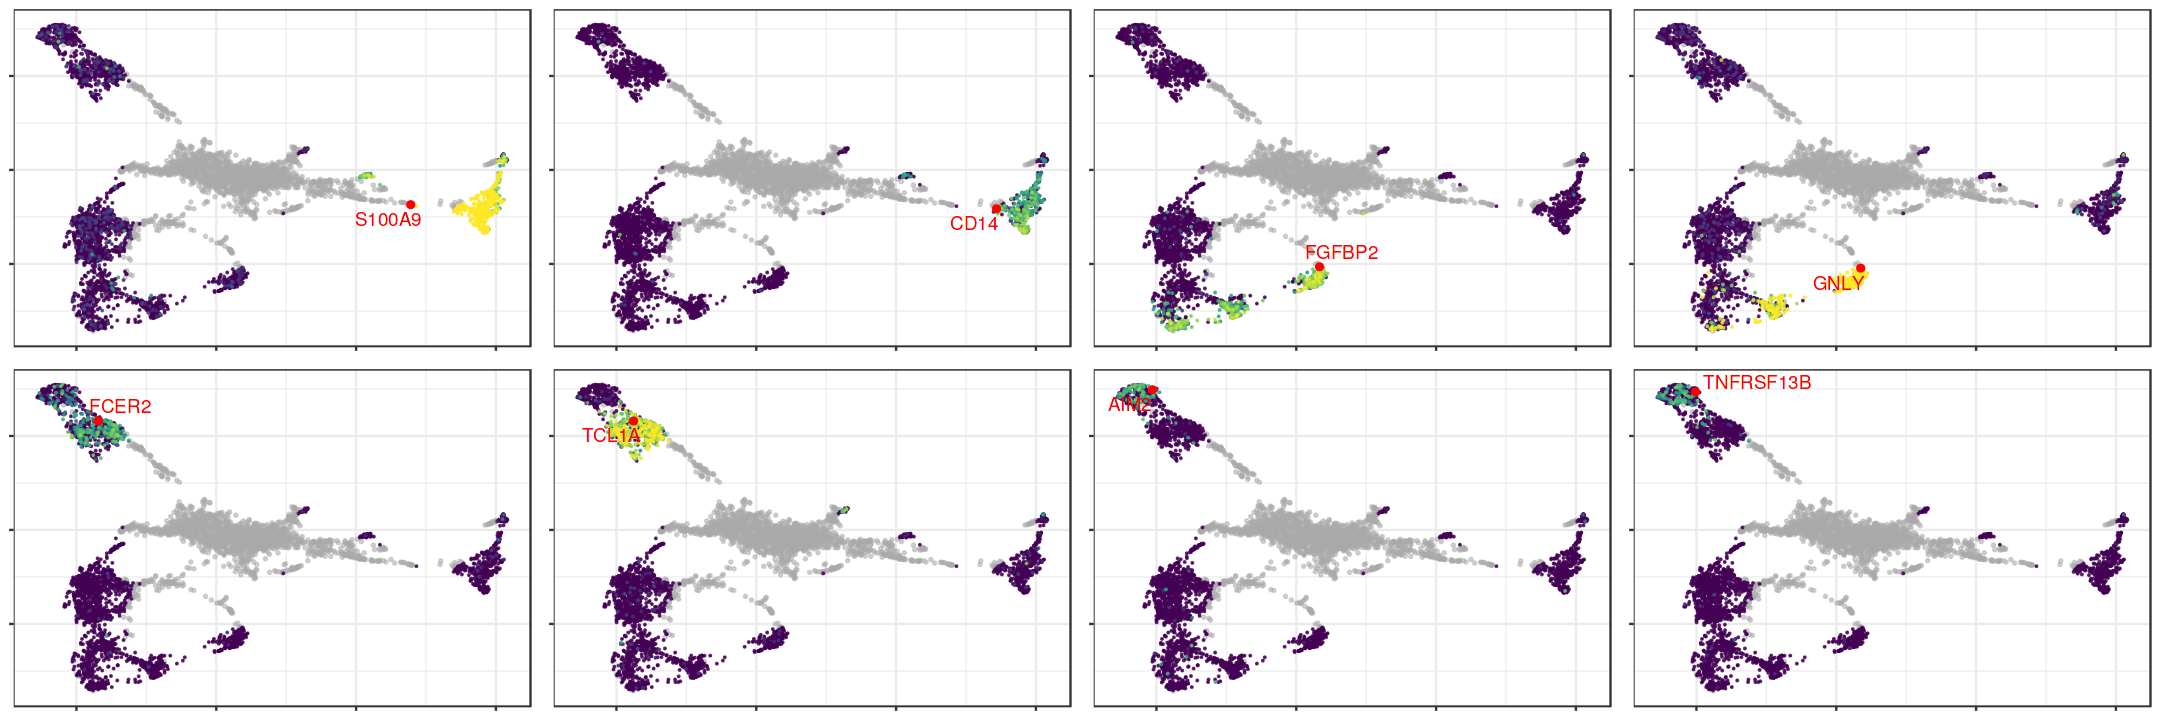

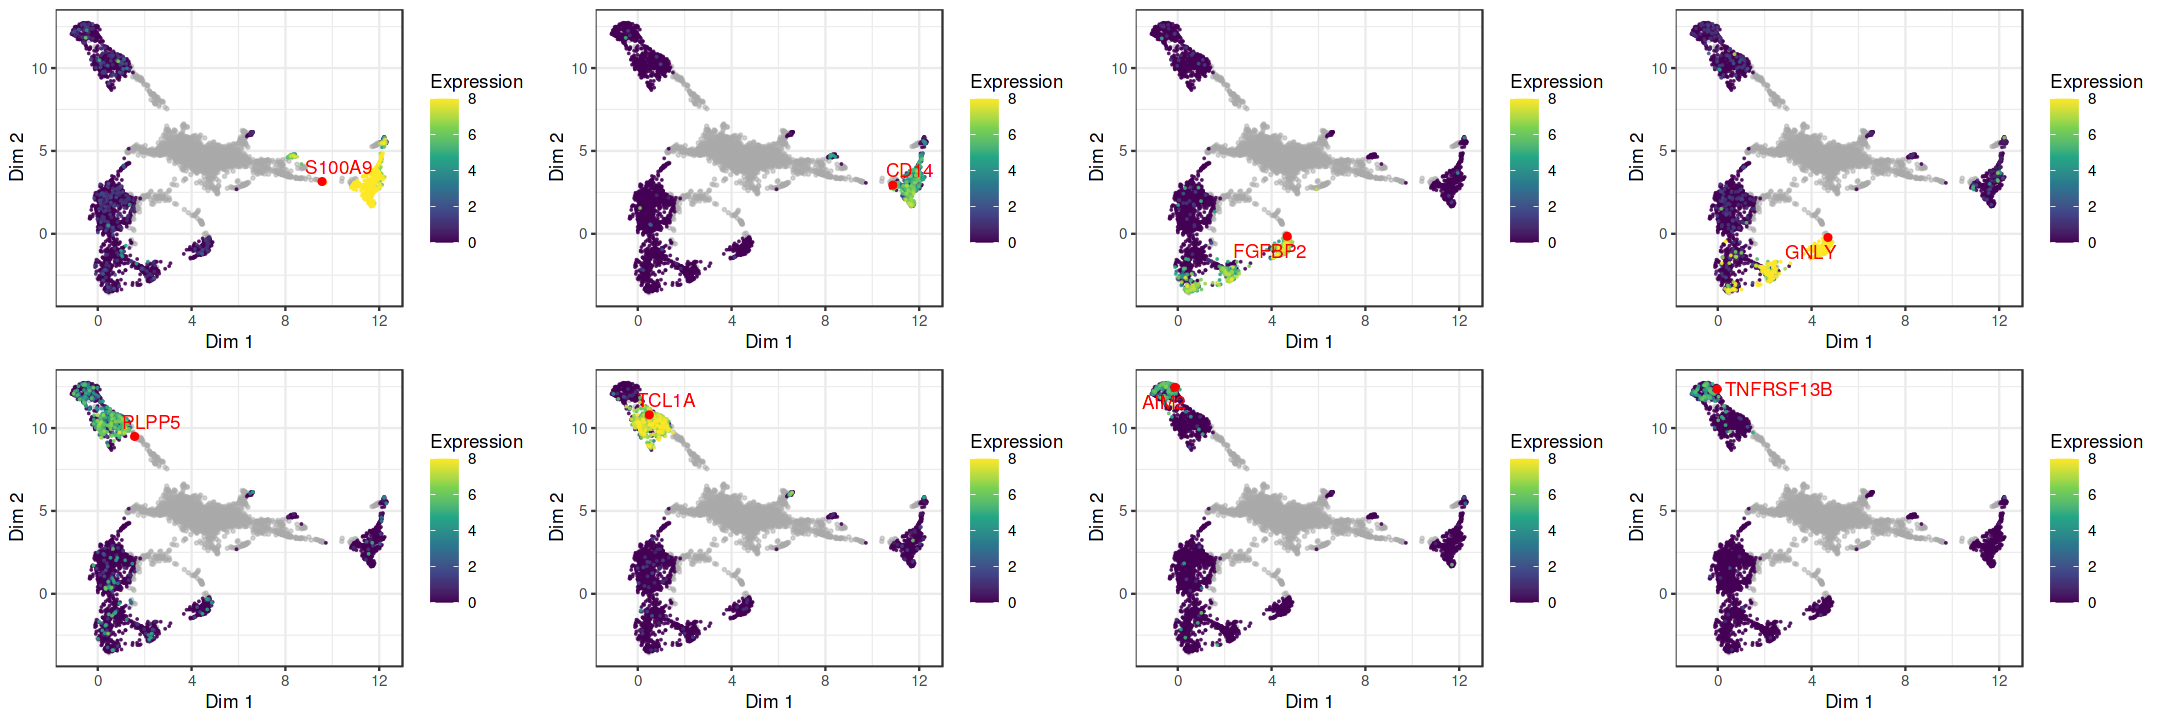

In [26]:
options(repr.plot.width=18, repr.plot.height=6)

p =features_biMAP(subdata, metadata(subdata)$caclust, 
               features = c('S100A9',  'CD14', 'FGFBP2', 'GNLY',  'FCER2', 'TCL1A',  'AIM2','TNFRSF13B'), 
                   cell_size = 0.05, gene_size = 0.5,
                  show_legend = FALSE,
                   show_labs = FALSE,
                   max_cutoff = 8,
                  ncol = 4,
                  filename = 'Fig2c_pbmc10x_markergenes_withoutlegends')+ 
            theme(legend.position = c(0.8, 0.2), 
                  legend.key.size = unit(0.2, 'cm'))

p = features_biMAP(subdata, metadata(subdata)$caclust, 
               features = c('S100A9',  'CD14', 'FGFBP2', 'GNLY',  'PLPP5', 'TCL1A', 'AIM2','TNFRSF13B'), 
                   cell_size = 0.05, gene_size = 0.5,
                  show_legend = TRUE,
                  ncol = 4,
                   width = 12,
                   height = 4,
                   max_cutoff = 8,
                  filename = 'Fig2c_pbmc10x_markergenes_withlegends')+ 
            theme(legend.position = c(0.8, 0.2), 
                  legend.key.size = unit(0.2, 'cm'))

### Supplementary Figure 3: the expression landscape of genes locating at the center of biMAP 

C1orf162  NDUFB10   CLEC2B     LSM2     IER2    PSME2 
      11       11       11       11       11       11 
Levels: 1 2 3 4 5 6 7 8 9 10 11

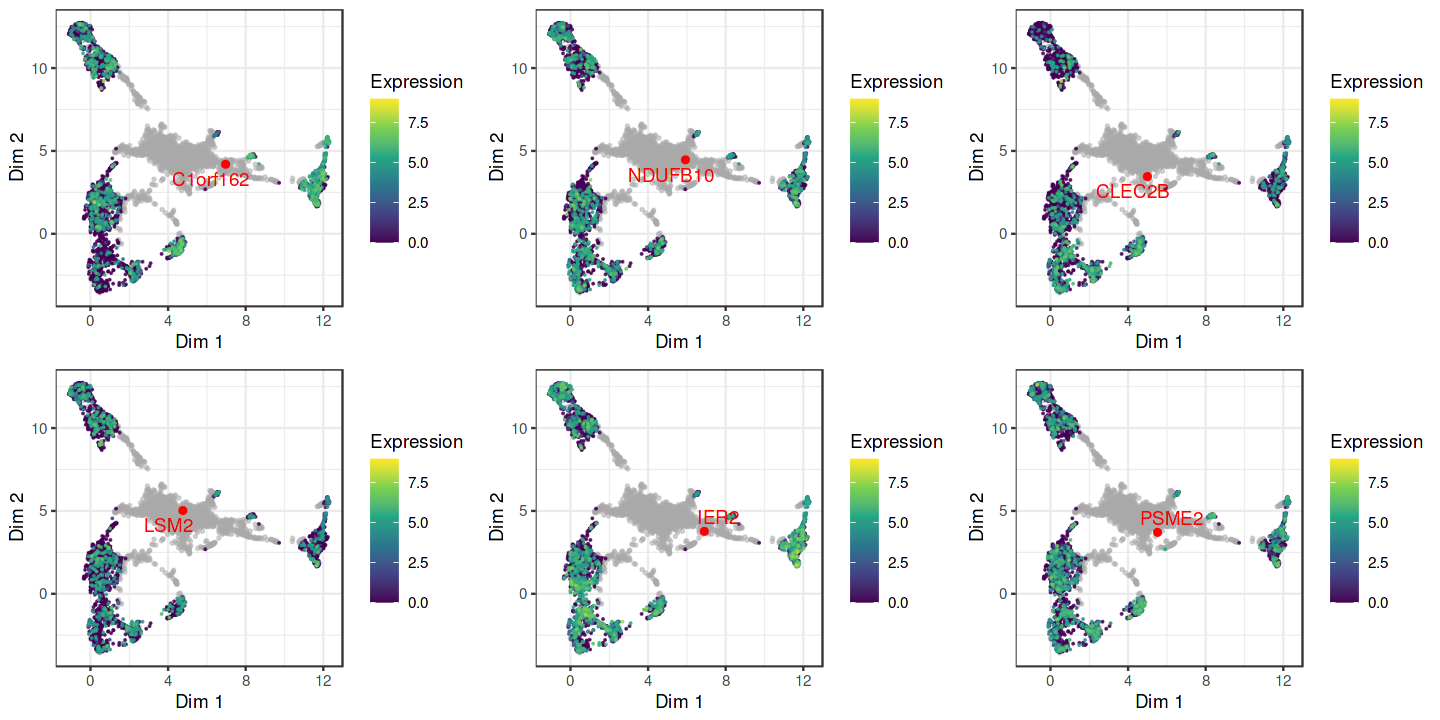

In [27]:
gene_clust = gene_clusters(metadata(subdata)$caclust)
head(gene_clust[gene_clust == 11])
options(repr.plot.width=12, repr.plot.height=6)

p = features_biMAP(subdata, metadata(subdata)$caclust, features = names(head(gene_clust[gene_clust == 11], n = 6)), 
                       cell_size = 0.05, gene_size = 0.5,
                  show_legend = TRUE,
                  ncol = 3,
                   width = 9,
                   height = 4,
                   max_cutoff = 9,
                  filename = NULL) 
options(repr.plot.width=9, repr.plot.height=6)

# ggsave('SFig_pbmc10x_markergenes_withlegends.png', p, width = 9, height = 4)
ggsave('imgs/SFig3_pbmc10x_markergenes_withlegends.pdf', p, width = 9, height = 4)

# p = features_biMAP(subdata, metadata(subdata)$caclust, 
#                features = names(head(gene_clust[gene_clust == 11], n = 6)),  
#                    cell_size = 0.05, gene_size = 0.5,
#                   show_legend = FALSE,
#                    show_labs = FALSE,
#                    max_cutoff = 9,
#                   ncol = 3,
#                    width = 6,
#                    height = 4,
#                   filename = NULL)

## R environment

In [28]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: MarIuX64 2.0 GNU/Linux

Matrix products: default
BLAS:   /pkg/R-4.2.1-0/lib/R/lib/libRblas.so
LAPACK: /pkg/R-4.2.1-0/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8 LC_NUMERIC=C         LC_TIME=C           
 [4] LC_COLLATE=C         LC_MONETARY=C        LC_MESSAGES=C       
 [7] LC_PAPER=C           LC_NAME=C            LC_ADDRESS=C        
[10] LC_TELEPHONE=C       LC_MEASUREMENT=C     LC_IDENTIFICATION=C 

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] plotly_4.10.2               ggsankey_0.0.99999         
 [3] ggthemes_4.2.4              CAbiNet_0.99.1             
 [5] APL_1.2.0                   reticulate_1.31            
 [7] umap_0.2.10.0               SeuratObject_4.1.3         
 [9] Seurat_4.3.0.1              sva_3.44.0                 
[11] BiocParallel_1.32.6         genefilt